In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/final_data_2.zip

Archive:  /content/drive/MyDrive/final_data_2.zip
replace final_data_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math 
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import math

In [2]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def memory_reduction(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'
          .format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
df = pd.read_csv('final_data_2.csv')
df.head()

,Unnamed: 0,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,...,log_meter_reading,month,day,hour,day_week,day_of_week,log_square_feet,relative_humidity,season,is_weekend
0,0,46,0,1451606400000000000,53.2397,0,Retail,9045,25.0,6.0,...,3.993413,1,1,0,4,friday,9.110078,73.802512,Winter,0
1,1,74,0,1451606400000000000,43.0013,0,Parking,387638,25.0,6.0,...,3.784219,1,1,0,4,friday,12.867830,73.802512,Winter,0
2,2,93,0,1451606400000000000,52.4206,0,Office,33370,25.0,6.0,...,3.978196,1,1,0,4,friday,10.415443,73.802512,Winter,0
3,3,105,0,1451606400000000000,23.3036,1,Education,50623,3.8,0.0,...,3.190625,1,1,0,4,friday,10.832181,90.575533,Winter,0
4,4,106,0,1451606400000000000,0.3746,1,Education,5374,3.8,0.0,...,0.318163,1,1,0,4,friday,8.589514,90.575533,Winter,0


In [ ]:
df.drop(['Unnamed: 0','meter_type'],axis=1,inplace=True)

In [ ]:
df.rename(columns={"log_meter_reading": "meter_readings"}, inplace=True)


In [ ]:
df.drop(['meter_reading'],axis=1,inplace=True)

## Baseline Model

In [ ]:
y_pred = df.groupby(['site_id','primary_use'])['meter_readings'].mean().reset_index()
print(y_pred)                    

     site_id                    primary_use  meter_readings
0          0                      Education        6.169210
1          0  Entertainment/public assembly        5.621823
2          0            Lodging/residential        5.808366
3          0                         Office        5.300796
4          0                          Other        4.612200
..       ...                            ...             ...
105       15                         Office        3.957416
106       15                Public services        4.669333
107       15              Religious worship        2.004993
108       15             Technology/science        4.948079
109       15                        Utility        5.162802

[110 rows x 3 columns]


### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
df = df.sort_values(by='timestamp')
X_train,X_cv = train_test_split(df,test_size=0.20,shuffle=False)
print('X_train shape: ',X_train.shape)
print('X_cv shape: ',X_cv.shape)

X_train shape:  (15663056, 23)
X_cv shape:  (3915764, 23)


In [ ]:
y_pred.rename(columns={'meter_readings':'y_pred_base'},inplace=True)
X_train =X_train.merge(y_pred,on=['site_id','primary_use'],how='left')
X_cv = X_cv.merge(y_pred,on=['site_id','primary_use'],how='left')

#### RMSLE Score for Baseline model

In [ ]:
X_train_base = math.sqrt(mean_squared_error(X_train['meter_readings'],X_train['y_pred_base']))
X_cv_base = math.sqrt(mean_squared_error(X_cv['meter_readings'],X_cv['y_pred_base']))

print("RMSLE score for baseline model for train data : ",X_train_base)
print("RMSLE score for baseline model for validation data : ",X_cv_base)

RMSLE score for baseline model for train data :  1.9008636152192406
RMSLE score for baseline model for validation data :  1.9142640591544056


In [ ]:
y_train = X_train['meter_readings']
y_cv = X_cv['meter_readings']
X_train.drop(['meter_readings','y_pred_base'],axis=1,inplace=True)
X_cv.drop(['meter_readings','y_pred_base'],axis=1,inplace=True)

### Removing collinear features

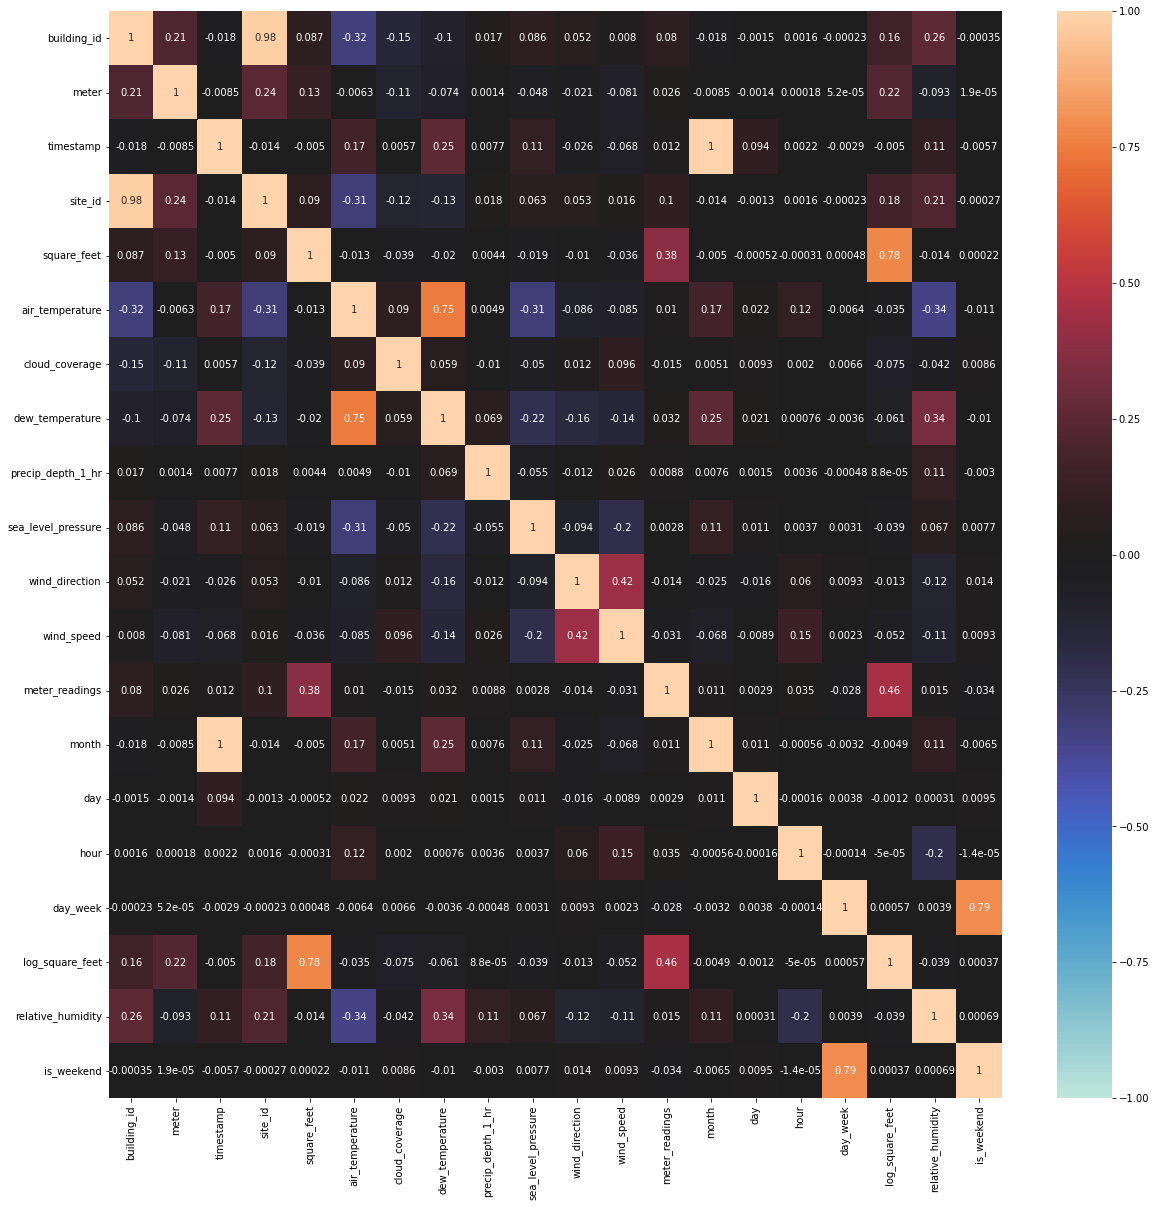

In [ ]:
df_corr = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(df_corr,annot=True,vmin=-1,vmax=1,center=0)

Since features like (site_id,building_id),(month,timestamp),(sqaure_feet,log_square_feet),(air_temperature,dew_temperature),(is_weekend,day_week) are very much correlated to each other we will drop one of the features among the two features. 

In [ ]:
X_train.drop(['site_id','dew_temperature','timestamp','square_feet','day_week'],axis=1,inplace=True)
X_cv.drop(['site_id','dew_temperature','timestamp','square_feet','day_week'],axis=1,inplace=True)

### LabelEncoding Categorical features

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

encoder.fit(X_train['primary_use'])
X_train['primary_use'] = encoder.transform(X_train['primary_use'])
X_cv['primary_use'] = encoder.transform(X_cv['primary_use'])

encoder.fit(X_train['season'])
X_train['season'] = encoder.transform(X_train['season'])
X_cv['season'] = encoder.transform(X_cv['season'])


In [ ]:
encoder.fit(X_train['day_of_week'])
X_train['day_of_week'] = encoder.transform(X_train['day_of_week'])
X_cv['day_of_week'] = encoder.transform(X_cv['day_of_week'])

In [ ]:
X_train.to_pickle('X_train_new.pkl')
X_cv.to_pickle('X_cv_new.pkl')
y_train.to_pickle('y_train_new.pkl')
y_cv.to_pickle('y_cv_new.pkl')

In [3]:
X_train= pd.read_pickle('/content/drive/MyDrive/X_train_new.pkl')
X_cv= pd.read_pickle('/content/drive/MyDrive/X_cv_new.pkl')
y_train=pd.read_pickle('/content/drive/MyDrive/y_train_new.pkl')
y_cv= pd.read_pickle('/content/drive/MyDrive/y_cv_new.pkl')

## Model building

### Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import math 
from sklearn.metrics import mean_squared_error
cv_error_array=[]
depth=[3,5,7,9,11,15]
for i in depth:
  d_reg=DecisionTreeRegressor(max_depth=i)
  d_reg.fit(X_train,y_train)
  y_pred=d_reg.predict(X_cv)
  cv_error_array.append(math.sqrt(mean_squared_error(y_cv, y_pred)))
  print("rmse for max_depth:", i,'is',math.sqrt(mean_squared_error(y_cv, y_pred)))

rmse for max_depth: 3 is 1.808971732460921
rmse for max_depth: 5 is 1.755981620515152
rmse for max_depth: 7 is 1.685356690135354
rmse for max_depth: 9 is 1.541287803624619
rmse for max_depth: 11 is 1.4540669124130565
rmse for max_depth: 15 is 1.3429288308254983


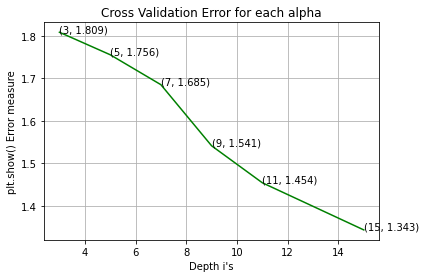

In [ ]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(depth, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((depth[i],np.round(txt,3)), (depth[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Depth i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [ ]:
dt=DecisionTreeRegressor(max_depth=depth[best_alpha],random_state=7)
dt.fit(X_train,y_train)
y_pred_train=d_reg.predict(X_train)
y_pred_cv=d_reg.predict(X_cv)
print("Train rmse for max_depth:", depth[best_alpha],'is',math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("CV rmse for max_depth:", depth[best_alpha],'is',math.sqrt(mean_squared_error(y_cv, y_pred_cv)))

Train rmse for max_depth: 15 is 0.8941485677297055
CV rmse for max_depth: 15 is 1.3429288308254983


In [ ]:
import joblib
filename='decision_tree_model.sav'
joblib.dump(dt,filename)

['decision_tree_model.sav']

### LGBM Random forest Regressor

In [ ]:
import lightgbm as lgb
estimators=[1,2,5,10,25,50,75,100,300,500]
cv_error_array=[]
for i in estimators:
    rf_reg=lgb.LGBMRegressor(boosting_type='rf', n_estimators=i, n_jobs=-1,objective='rmse',subsample=0.8,feature_fraction=0.8,bagging_freq=1)
    rf_reg.fit(X_train,y_train)
    y_pred=rf_reg.predict(X_cv)
    cv_error_array.append(math.sqrt(mean_squared_error(y_cv, y_pred)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_cv, y_pred)))

rmse for estimators: 1 is 1.7529401306520296
rmse for estimators: 2 is 1.6729019962232565
rmse for estimators: 5 is 1.5947419419313957
rmse for estimators: 10 is 1.6155683471019562
rmse for estimators: 25 is 1.6099561020334003
rmse for estimators: 50 is 1.6168387875151238
rmse for estimators: 75 is 1.6179057191604307
rmse for estimators: 100 is 1.6238075362622042
rmse for estimators: 300 is 1.628512042147503
rmse for estimators: 500 is 1.6284286902933487


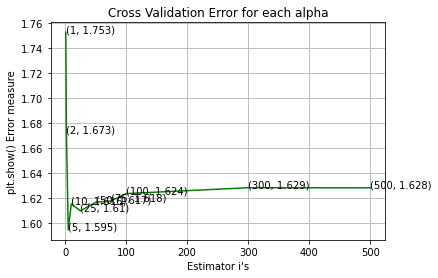

In [ ]:
best_estimators = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(estimators,cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((estimators[i],np.round(txt,3)), (estimators[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [ ]:
lgbm_rf=lgb.LGBMRegressor(boosting_type='rf', n_estimators=estimators[best_estimators], n_jobs=-1,objective='rmse',subsample=0.8,feature_fraction=0.8,bagging_freq=1)
lgbm_rf.fit(X_train,y_train)
y_pred_train=lgbm_rf.predict(X_train)
y_pred_cv=lgbm_rf.predict(X_cv)
print("Train rmse for best estimators:", estimators[best_estimators],'is',math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("CV rmse for best estimators:", estimators[best_estimators],'is',math.sqrt(mean_squared_error(y_cv, y_pred_cv)))

Train rmse for best estimators: 5 is 1.618433573019579
CV rmse for best estimators: 5 is 1.5947419419313957


In [ ]:
filename='lgbm_rf_model.sav'
joblib.dump(lgbm_rf,filename)

['lgbm_rf_model.sav']

### LGBM GBDT

In [ ]:
import lightgbm as lgb
lgb_estimators=[75,150,500,1000,2000]
cv_error_array=[]
for i in lgb_estimators:
    lgb_reg=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=i,objective='rmse', n_jobs=-1)
    lgb_reg.fit(X_train,y_train)
    y_pred = lgb_reg.predict(X_cv)
    cv_error_array.append(math.sqrt(mean_squared_error(y_cv, y_pred)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_cv, y_pred)))

rmse for estimators: 75 is 1.301538019048781
rmse for estimators: 150 is 1.2340964991540073
rmse for estimators: 500 is 1.1333198921752707
rmse for estimators: 1000 is 1.1012313163714968
rmse for estimators: 2000 is 1.0870242978270588


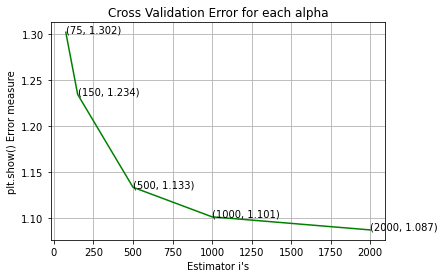

In [ ]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(lgb_estimators, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((lgb_estimators[i],np.round(txt,3)), (lgb_estimators[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [ ]:
lgb_reg=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=lgb_estimators[best_alpha], objective='rmse',n_jobs=-1)
lgb_reg.fit(X_train,y_train)
y_pred_train=lgb_reg.predict(X_train)
y_pred_cv=lgb_reg.predict(X_cv)
print("Train rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("CV rmse for estimators:", lgb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_cv, y_pred_cv)))

Train rmse for estimators: 2000 is 0.7108497047332908
CV rmse for estimators: 2000 is 1.0858132236832523


In [ ]:
filename='lgbm_gbdt_model.sav'
joblib.dump(lgb_reg,filename)

['lgbm_gbdt_model.sav']

### Catboost

In [ ]:
import catboost as cb
#from catboost import CatBoostRegressor
cb_estimators=[75,150,500,1000,1500]
cv_error_array=[]
for i in cb_estimators:
    cb_reg=cb.CatBoostRegressor(n_estimators=i)
    cb_reg.fit(X_train,y_train)
    y_pred=cb_reg.predict(X_cv)
    cv_error_array.append(math.sqrt(mean_squared_error(y_cv, y_pred)))
    print("rmse for estimators:", i,'is',math.sqrt(mean_squared_error(y_cv, y_pred)))

Learning rate set to 0.5
0:	learn: 1.8298189	total: 1.53s	remaining: 1m 53s
1:	learn: 1.7499049	total: 2.69s	remaining: 1m 38s
2:	learn: 1.6447563	total: 3.84s	remaining: 1m 32s
3:	learn: 1.5857737	total: 4.93s	remaining: 1m 27s
4:	learn: 1.5652333	total: 6.17s	remaining: 1m 26s
5:	learn: 1.5316482	total: 7.43s	remaining: 1m 25s
6:	learn: 1.5045962	total: 9.14s	remaining: 1m 28s
7:	learn: 1.4928067	total: 10.7s	remaining: 1m 29s
8:	learn: 1.4843159	total: 12s	remaining: 1m 28s
9:	learn: 1.4745561	total: 13.1s	remaining: 1m 25s
10:	learn: 1.4664276	total: 14.1s	remaining: 1m 21s
11:	learn: 1.4616972	total: 15.5s	remaining: 1m 21s
12:	learn: 1.4539686	total: 16.7s	remaining: 1m 19s
13:	learn: 1.4471691	total: 17.8s	remaining: 1m 17s
14:	learn: 1.4397855	total: 18.8s	remaining: 1m 15s
15:	learn: 1.4359146	total: 19.8s	remaining: 1m 13s
16:	learn: 1.4254989	total: 21.1s	remaining: 1m 11s
17:	learn: 1.4199675	total: 22.2s	remaining: 1m 10s
18:	learn: 1.4130860	total: 23.3s	remaining: 1m 8s


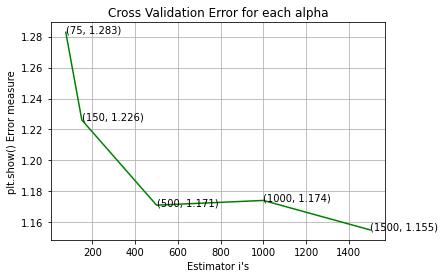

In [ ]:
best_alpha = np.argmin(cv_error_array)
fig, ax = plt.subplots()
ax.plot(cb_estimators, cv_error_array,c='g')
for i, txt in enumerate(np.round(cv_error_array,3)):
  ax.annotate((cb_estimators[i],np.round(txt,3)), (cb_estimators[i],cv_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [ ]:
cb_reg=cb.CatBoostRegressor(n_estimators=cb_estimators[best_alpha])
cb_reg.fit(X_train,y_train)
y_pred_train=cb_reg.predict(X_train)
y_pred_cv=cb_reg.predict(X_cv)
print("Train rmse for estimators:", cb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("CV rmse for estimators:", cb_estimators[best_alpha],'is',math.sqrt(mean_squared_error(y_cv, y_pred_cv)))

Learning rate set to 0.135459
0:	learn: 1.9821004	total: 1.18s	remaining: 29m 26s
1:	learn: 1.9181334	total: 2.35s	remaining: 29m 18s
2:	learn: 1.8713518	total: 3.41s	remaining: 28m 24s
3:	learn: 1.8327092	total: 4.58s	remaining: 28m 33s
4:	learn: 1.8022857	total: 5.62s	remaining: 28m 1s
5:	learn: 1.7764641	total: 6.71s	remaining: 27m 50s
6:	learn: 1.7567621	total: 7.82s	remaining: 27m 48s
7:	learn: 1.7378976	total: 8.9s	remaining: 27m 39s
8:	learn: 1.7158441	total: 10s	remaining: 27m 37s
9:	learn: 1.7014358	total: 11.1s	remaining: 27m 39s
10:	learn: 1.6915084	total: 12.2s	remaining: 27m 26s
11:	learn: 1.6821453	total: 13.3s	remaining: 27m 27s
12:	learn: 1.6624153	total: 14.4s	remaining: 27m 32s
13:	learn: 1.6546843	total: 15.5s	remaining: 27m 27s
14:	learn: 1.6323128	total: 16.6s	remaining: 27m 26s
15:	learn: 1.6112036	total: 17.8s	remaining: 27m 28s
16:	learn: 1.6009988	total: 18.8s	remaining: 27m 20s
17:	learn: 1.5838658	total: 19.9s	remaining: 27m 21s
18:	learn: 1.5793159	total: 20

In [ ]:
filename='catboost_model.sav'
joblib.dump(cb_reg,filename)

['catboost_model.sav']

### Catboost with Regularization

In [11]:
import catboost as cb
cb_reg_r=cb.CatBoostRegressor(n_estimators=1500,l2_leaf_reg=3,task_type='GPU')
cb_reg_r.fit(X_train,y_train)
y_pred_train=cb_reg_r.predict(X_train)
y_pred_cv=cb_reg_r.predict(X_cv)
print("Train rmse for estimators 1500 is: ",math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("CV rmse for estimators 1500 is: ",math.sqrt(mean_squared_error(y_cv, y_pred_cv)))

0:	learn: 2.0389592	total: 67.4ms	remaining: 1m 40s
1:	learn: 2.0226112	total: 132ms	remaining: 1m 38s
2:	learn: 2.0071275	total: 197ms	remaining: 1m 38s
3:	learn: 1.9925390	total: 259ms	remaining: 1m 36s
4:	learn: 1.9785526	total: 322ms	remaining: 1m 36s
5:	learn: 1.9657125	total: 384ms	remaining: 1m 35s
6:	learn: 1.9534031	total: 446ms	remaining: 1m 35s
7:	learn: 1.9399886	total: 509ms	remaining: 1m 34s
8:	learn: 1.9287388	total: 571ms	remaining: 1m 34s
9:	learn: 1.9176993	total: 631ms	remaining: 1m 34s
10:	learn: 1.9072511	total: 691ms	remaining: 1m 33s
11:	learn: 1.8941800	total: 754ms	remaining: 1m 33s
12:	learn: 1.8846267	total: 814ms	remaining: 1m 33s
13:	learn: 1.8754942	total: 875ms	remaining: 1m 32s
14:	learn: 1.8668949	total: 935ms	remaining: 1m 32s
15:	learn: 1.8584009	total: 998ms	remaining: 1m 32s
16:	learn: 1.8505007	total: 1.06s	remaining: 1m 32s
17:	learn: 1.8430223	total: 1.12s	remaining: 1m 32s
18:	learn: 1.8325242	total: 1.18s	remaining: 1m 32s
19:	learn: 1.8253668	

In [12]:
import joblib
filename='catboost_r_model.sav'
joblib.dump(cb_reg_r,filename)

['catboost_r_model.sav']

### XGB Regressor

In [ ]:
from xgboost import XGBRegressor
max_depth_xgb= [3,5,9,13,21] 
rmse_xgb = []
for i in max_depth_xgb:
    xgb_clf =XGBRegressor(n_estimators=50,max_depth = i,nthread=-1,verbose = 1)
    xgb_clf.fit(X_train,y_train)
    y_pred =  xgb_clf.predict(X_cv)
    error = math.sqrt(mean_squared_error(y_cv, y_pred))
    rmse_xgb.append(error)
    print ('rmse for estimators = ',i,'is',error)

[13:25:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:55] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
rmse for estimators =  3 is 1.6495072210720712
[13:36:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:54] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
rmse for estimators =  5 is 1.5347839257687133
[13:52:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:43] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'a

best_alpha 2


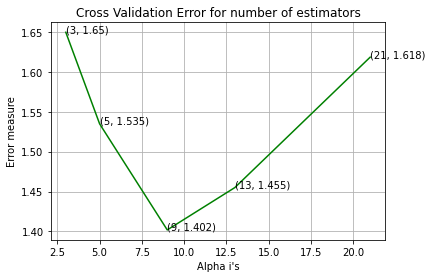

In [ ]:
best_est = np.argmin(rmse_xgb)
print("best_alpha",best_est)
fig, ax = plt.subplots()
ax.plot(max_depth_xgb, rmse_xgb,c='g')
for i, txt in enumerate(np.round(rmse_xgb,3)):
    ax.annotate((max_depth_xgb[i],np.round(txt,3)), (max_depth_xgb[i],rmse_xgb[i]))
plt.grid()
plt.title("Cross Validation Error for number of estimators")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
xgb_clf =XGBRegressor(n_estimators=50,max_depth = max_depth_xgb[best_est],nthread=-1,verbose = 1)
xgb_clf.fit(X_train,y_train)
y_pred_train= xgb_clf.predict(X_train)
y_pred_cv= xgb_clf.predict(X_cv)
print("Train rmse for alpha:", max_depth_xgb[best_est],'is',math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("CV rmse for alpha:", max_depth_xgb[best_est],'is',math.sqrt(mean_squared_error(y_cv, y_pred_cv)))

[16:37:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:42] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Train rmse for alpha: 9 is 1.0896097001162515
CV rmse for alpha: 9 is 1.4018980251387005


In [ ]:
filename = 'xgb_regressor_model.sav'
joblib.dump(xgb_clf,filename)

['xgb_regressor_model.sav']

### XGB Regressor with L1 and L2 Regularization

#### L2

In [15]:
from xgboost import XGBRegressor
xgb_clf_l2 =XGBRegressor(n_estimators=50,max_depth = 9,nthread=-1,verbose = 1,reg_alpha=0,reg_lambda=2)
xgb_clf_l2.fit(X_train,y_train)
y_pred_train= xgb_clf_l2.predict(X_train)
y_pred_cv= xgb_clf_l2.predict(X_cv)
print("Train rmse for alpha is : ",math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("CV rmse for alpha is : ",math.sqrt(mean_squared_error(y_cv, y_pred_cv)))

[09:10:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:41] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Train rmse for alpha is :  1.0959960038437335
CV rmse for alpha is :  1.2395620746494238


In [17]:
filename = 'xgb_regressor_l2_model.sav'
joblib.dump(xgb_clf_l2,filename)

['xgb_regressor_l2_model.sav']

#### L1

In [16]:
xgb_clf_l1 =XGBRegressor(n_estimators=50,max_depth = 9,nthread=-1,verbose = 1,reg_alpha=2,reg_lambda=0)
xgb_clf_l1.fit(X_train,y_train)
y_pred_train= xgb_clf_l1.predict(X_train)
y_pred_cv= xgb_clf_l1.predict(X_cv)
print("Train rmse for alpha is : ",math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("CV rmse for alpha is : ",math.sqrt(mean_squared_error(y_cv, y_pred_cv)))

[09:37:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:37:55] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Train rmse for alpha is :  1.086475236552483
CV rmse for alpha is :  1.237727674433729


In [18]:
filename = 'xgb_regressor_l1_model.sav'
joblib.dump(xgb_clf_l1,filename)

['xgb_regressor_l1_model.sav']

### Scalling of features for LR and SVR

In [ ]:
from sklearn.preprocessing import StandardScaler
def standardizing(df,col) :
    scaler = StandardScaler()
    scaler.fit(df[col].values.reshape(-1, 1))
    df[col]=scaler.transform(df[col].values.reshape(-1, 1))
    return df

In [ ]:
X_train_scaled = X_train
num_features = X_train_scaled.columns.tolist()
num_features
for i in num_features :
   standardizing(X_train_scaled,i)

In [ ]:
X_cv_scaled = X_cv
num_features = X_cv_scaled.columns.tolist()
num_features
for i in num_features :
   standardizing(X_cv_scaled,i)

In [ ]:
memory_reduction(X_train_scaled, use_float16=True)
memory_reduction(X_cv_scaled, use_float16=True)

Memory usage of dataframe is 2150.99 MB
Memory usage after optimization is: 627.37 MB
Decreased by 70.8%
Memory usage of dataframe is 537.75 MB
Memory usage after optimization is: 156.84 MB
Decreased by 70.8%


,building_id,meter,primary_use,air_temperature,cloud_coverage,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,hour,day_of_week,log_square_feet,relative_humidity,season,is_weekend
0,1.296875,-0.719727,0.242920,-0.577637,-0.467041,-0.328613,-2.000000,1.221680,1.443359,-1.876953,0.516113,-0.079407,-0.501465,-0.015343,1.198242,-0.881348,1.563477
1,1.296875,0.354492,0.242920,-0.577637,-0.467041,-0.328613,-2.000000,1.221680,1.443359,-1.876953,0.516113,-0.079407,-0.501465,-0.015343,1.198242,-0.881348,1.563477
2,1.296875,1.428711,0.242920,-0.577637,-0.467041,-0.328613,-2.000000,1.221680,1.443359,-1.876953,0.516113,-0.079407,-0.501465,-0.015343,1.198242,-0.881348,1.563477
3,1.248047,0.354492,0.823242,-0.577637,-0.467041,-0.328613,-2.000000,1.221680,1.443359,-1.876953,0.516113,-0.079407,-0.501465,-1.234375,1.198242,-0.881348,1.563477
4,1.317383,-0.719727,-0.917969,-0.577637,-0.467041,-0.328613,-2.000000,1.221680,1.443359,-1.876953,0.516113,-0.079407,-0.501465,-0.528320,1.198242,-0.881348,1.563477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915759,-0.466309,-0.719727,-0.627930,0.327393,0.526855,-0.107666,-0.687012,-1.282227,-0.504883,1.005859,1.513672,1.654297,-0.501465,-1.416016,-0.710938,1.134766,1.563477
3915760,-0.464111,-0.719727,-0.627930,0.327393,0.526855,-0.107666,-0.687012,-1.282227,-0.504883,1.005859,1.513672,1.654297,-0.501465,1.141602,-0.710938,1.134766,1.563477
3915761,-0.461670,-0.719727,1.694336,0.327393,0.526855,-0.107666,-0.687012,-1.282227,-0.504883,1.005859,1.513672,1.654297,-0.501465,-0.654297,-0.710938,1.134766,1.563477
3915762,-0.499023,-0.719727,2.855469,0.327393,0.526855,-0.107666,-0.687012,-1.282227,-0.504883,1.005859,1.513672,1.654297,-0.501465,-0.137695,-0.710938,1.134766,1.563477


### SGD Regressor (LR)

In [ ]:
from sklearn.linear_model import SGDRegressor
import math
alpha_sgd = [10 ** x for x in range(-5, 2)]
rmse_sgd = []
for i in alpha_sgd: 
    sgd_clf = SGDRegressor(alpha = i,loss='squared_loss', eta0=0.01, verbose=0,random_state=42, penalty='l2',early_stopping=True)
    sgd_clf.fit(X_train_scaled, y_train)
    y_pred =  sgd_clf.predict(X_cv_scaled)
    error = math.sqrt(mean_squared_error(y_cv, y_pred))
    print ('rmse for alpha = ',i,'is',error)
    rmse_sgd.append(error)

rmse for alpha =  1e-05 is 1.8489977532367903
rmse for alpha =  0.0001 is 1.8489919747215324
rmse for alpha =  0.001 is 1.8489347325581624
rmse for alpha =  0.01 is 1.8485672971528144
rmse for alpha =  0.1 is 1.84713549266859
rmse for alpha =  1 is 1.898829211560115
rmse for alpha =  10 is 2.0254726736665636


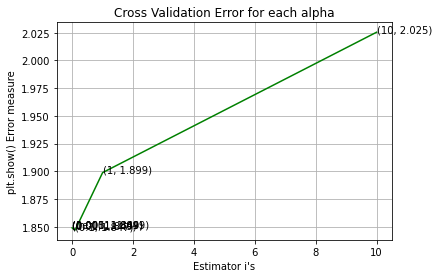

In [ ]:
best_alpha = np.argmin(rmse_sgd)
fig, ax = plt.subplots()
ax.plot(alpha_sgd, rmse_sgd,c='g')
for i, txt in enumerate(np.round(rmse_sgd,3)):
  ax.annotate((alpha_sgd[i],np.round(txt,3)), (alpha_sgd[i],rmse_sgd[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [ ]:
sgd_reg=SGDRegressor(alpha = alpha_sgd[best_alpha],loss='squared_loss', eta0=0.01, verbose=0,random_state=42, penalty='l2',early_stopping=True)
sgd_reg.fit(X_train_scaled,y_train)
y_pred_train=sgd_reg.predict(X_train_scaled)
y_pred_cv=sgd_reg.predict(X_cv_scaled)
print("Train rmse for alpha:", alpha_sgd[best_alpha],'is',math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("CV rmse for alpha:", alpha_sgd[best_alpha],'is',math.sqrt(mean_squared_error(y_cv, y_pred_cv)))

Train rmse for alpha: 0.1 is 1.806365940011163
CV rmse for alpha: 0.1 is 1.84713549266859


In [ ]:
import joblib
filename='sgd_lr_model.sav'
joblib.dump(sgd_reg,filename)

['sgd_lr_model.sav']

### SGD (SVR)

In [ ]:
from sklearn.linear_model import SGDRegressor
alpha_sgd = [10 ** x for x in range(-5, 2)]
rmse_sgd = []
for i in alpha_sgd: 
    sgd_reg_svr = SGDRegressor(alpha = i,loss='epsilon_insensitive', eta0=0.01, verbose=0,random_state=42, penalty='l2',early_stopping=True)
    sgd_reg_svr.fit(X_train_scaled, y_train)
    y_pred =  sgd_reg_svr.predict(X_cv_scaled)
    error = math.sqrt(mean_squared_error(y_cv, y_pred))
    print ('rmse for alpha = ',i,'is',error)
    rmse_sgd.append(error)

rmse for alpha =  1e-05 is 1.8552213551769583
rmse for alpha =  0.0001 is 1.855246938885464
rmse for alpha =  0.001 is 1.855188093117791
rmse for alpha =  0.01 is 1.8559852875780816
rmse for alpha =  0.1 is 1.8516701075456774
rmse for alpha =  1 is 1.929170886421844
rmse for alpha =  10 is 2.0520359945524356


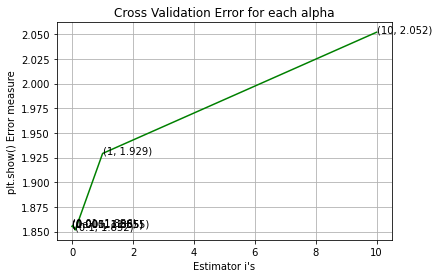

In [ ]:
best_alpha = np.argmin(rmse_sgd)
fig, ax = plt.subplots()
ax.plot(alpha_sgd, rmse_sgd,c='g')
for i, txt in enumerate(np.round(rmse_sgd,3)):
  ax.annotate((alpha_sgd[i],np.round(txt,3)), (alpha_sgd[i],rmse_sgd[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Estimator i's")
plt.ylabel("plt.show() Error measure")
plt.show()

In [ ]:
sgd_reg_svr = SGDRegressor(alpha = alpha_sgd[best_alpha],loss='epsilon_insensitive', eta0=0.01, verbose=0,random_state=42, penalty='l2',early_stopping=True)
sgd_reg_svr.fit(X_train_scaled,y_train)
y_pred_train=sgd_reg_svr.predict(X_train_scaled)
y_pred_cv=sgd_reg_svr.predict(X_cv_scaled)
print("Train rmse for alpha:", alpha_sgd[best_alpha],'is',math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("CV rmse for alpha:", alpha_sgd[best_alpha],'is',math.sqrt(mean_squared_error(y_cv, y_pred_cv)))

Train rmse for alpha: 0.1 is 1.8364308898171722
CV rmse for alpha: 0.1 is 1.8516701075456774


In [ ]:
import joblib
filename='sgd_svr_model.sav'
joblib.dump(sgd_reg_svr,filename)

['sgd_svr_model.sav']

## Observations

In [19]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Train_RMSE","CV_RMSE"]
table.add_row(["Baseline", 1.9008,1.9142])
table.add_row(["Decision Trees",0.8941,1.3429])
table.add_row(["LightGBM RF",1.6184,1.5947])
table.add_row(["LightGBM GBDT",0.7108,1.0858])
table.add_row(["Catboost", 0.9218,1.1551])
table.add_row(['Catboost_regularization',1.190,1.248])
table.add_row(["XGB Regresor",1.0896,1.4018])
table.add_row(["XGB Regresor L2",1.095,1.239])
table.add_row(["XGB Regresor L1",1.086,1.237])
table.add_row(["SGD LR",1.8063,1.8471])
table.add_row(["SGD SVR",1.8364,1.8516])
print(table)

+-------------------------+------------+---------+
|          Model          | Train_RMSE | CV_RMSE |
+-------------------------+------------+---------+
|         Baseline        |   1.9008   |  1.9142 |
|      Decision Trees     |   0.8941   |  1.3429 |
|       LightGBM RF       |   1.6184   |  1.5947 |
|      LightGBM GBDT      |   0.7108   |  1.0858 |
|         Catboost        |   0.9218   |  1.1551 |
| Catboost_regularization |    1.19    |  1.248  |
|       XGB Regresor      |   1.0896   |  1.4018 |
|     XGB Regresor L2     |   1.095    |  1.239  |
|     XGB Regresor L1     |   1.086    |  1.237  |
|          SGD LR         |   1.8063   |  1.8471 |
|         SGD SVR         |   1.8364   |  1.8516 |
+-------------------------+------------+---------+


Models like Decision Trees, LightGBM GBDT, and XGB Regressor overfit, but Catboost performs better than other models, as can be shown.

## Preprocessing Test.csv File

In [5]:
test_data = pd.read_csv('test.csv')
test_weather = pd.read_csv('weather_test.csv')
build_data = pd.read_csv('building_metadata.csv')

In [6]:
print(test_data.shape)
print(test_weather.shape)
print(build_data.shape)

(41697600, 4)
(277243, 9)
(1449, 6)


In [7]:
test_data.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [8]:
build_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [9]:
test_weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [10]:
test_data= memory_reduction(test_data, use_float16=True)
build_data= memory_reduction(build_data, use_float16=True)
test_weather= memory_reduction(test_weather, use_float16=True)

Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.53 MB
Decreased by 71.8%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.9%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 5.13 MB
Decreased by 73.0%


### Merging all Test Data

In [11]:
test_df= test_data.merge(build_data, on='building_id', how='left')
test_df.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN


In [12]:
X_test=test_df.merge(test_weather, on=['site_id', 'timestamp'], how='left')
X_test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


In [13]:
X_test.isnull().sum()/len(X_test)*100

row_id                 0.000000
building_id            0.000000
meter                  0.000000
timestamp              0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            58.991597
floor_count           82.605042
air_temperature        0.532167
cloud_coverage        46.866438
dew_temperature        0.625453
precip_depth_1_hr     18.709861
sea_level_pressure     6.035901
wind_direction         7.143488
wind_speed             0.724476
dtype: float64

In [14]:
X_test.drop(['year_built','floor_count'],axis=1,inplace=True)

In [15]:
X_test['air_temperature'] = X_test['air_temperature'].fillna(X_test['air_temperature'].median())
X_test['cloud_coverage'] = X_test['cloud_coverage'].fillna(X_test['cloud_coverage'].median())
X_test['precip_depth_1_hr'] = X_test['precip_depth_1_hr'].fillna(X_test['precip_depth_1_hr'].median())
X_test['sea_level_pressure'] = X_test['sea_level_pressure'].fillna(X_test['sea_level_pressure'].median())
X_test['wind_direction'] = X_test['wind_direction'].fillna(X_test['wind_direction'].median())
X_test['dew_temperature'] = X_test['dew_temperature'].fillna(X_test['dew_temperature'].median())
X_test['wind_speed'] = X_test['wind_speed'].fillna(X_test['wind_speed'].median())

In [16]:
X_test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,17.796875,4.0,11.703125,0.0,1021.5,100.0,3.599609
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,17.796875,4.0,11.703125,0.0,1021.5,100.0,3.599609
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,17.796875,4.0,11.703125,0.0,1021.5,100.0,3.599609
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,17.796875,4.0,11.703125,0.0,1021.5,100.0,3.599609
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,17.796875,4.0,11.703125,0.0,1021.5,100.0,3.599609


In [17]:
X_test['timestamp'] = pd.to_datetime(X_test['timestamp'],format='%Y-%m-%d %H:%M')
X_test['month'] = X_test['timestamp'].dt.month
X_test['day'] = X_test['timestamp'].dt.day
X_test['hour'] = X_test['timestamp'].dt.hour
X_test['day_week'] = X_test['timestamp'].dt.dayofweek
X_test['day_of_week']=X_test['day_week'].map({0:'monday',1:'tuesday',2:'wednesday',3:'thursday',4:'friday',5:'saturday',6:'sunday'})
X_test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,hour,day_week,day_of_week
0,0,0,0,2017-01-01,0,Education,7432,17.796875,4.0,11.703125,0.0,1021.5,100.0,3.599609,1,1,0,6,sunday
1,1,1,0,2017-01-01,0,Education,2720,17.796875,4.0,11.703125,0.0,1021.5,100.0,3.599609,1,1,0,6,sunday
2,2,2,0,2017-01-01,0,Education,5376,17.796875,4.0,11.703125,0.0,1021.5,100.0,3.599609,1,1,0,6,sunday
3,3,3,0,2017-01-01,0,Education,23685,17.796875,4.0,11.703125,0.0,1021.5,100.0,3.599609,1,1,0,6,sunday
4,4,4,0,2017-01-01,0,Education,116607,17.796875,4.0,11.703125,0.0,1021.5,100.0,3.599609,1,1,0,6,sunday


In [18]:
X_test['log_square_feet'] = np.log1p(X_test['square_feet'])

In [19]:
X_test['relative_humidity'] =100*((np.exp((17.625*X_test['dew_temperature'])/(243.04+X_test['dew_temperature'])))/(np.exp((17.625*X_test['air_temperature'])/(243.04+X_test['air_temperature']))))

In [20]:
def seasons(x):
    if x==3 or x==4 or x==5:
        return 'Spring'
    elif x==6 or x==7 or x==8:
        return 'Summer'
    elif  x==9 or x==10 or x==11:
        return 'Autumn'
    else:
        return 'Winter'

In [21]:
X_test['season']=X_test.month.apply(seasons)

In [22]:
def weekend(x):
    if x==5 or x==6:
        return 1
    else:
        return 0

In [23]:
X_test['is_weekend']=X_test.day_week.apply(weekend)

In [24]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

encoder.fit(X_test['primary_use'])
X_test['primary_use'] = encoder.transform(X_test['primary_use'])

encoder.fit(X_test['season'])
X_test['season'] = encoder.transform(X_test['season'])

encoder.fit(X_test['day_of_week'])
X_test['day_of_week'] = encoder.transform(X_test['day_of_week'])

In [25]:
a = list(X_test.columns)
b = list(X_train.columns)
feature = []
for i in a:
  if i not in b:
    feature.append(i)
print(feature)

['row_id', 'timestamp', 'site_id', 'square_feet', 'dew_temperature', 'day_week']


In [26]:
X_test.drop(['site_id','dew_temperature','timestamp','square_feet','day_week'],axis=1,inplace=True)

In [27]:
X_test.to_pickle('X_test.pkl')

In [2]:
X_test = pd.read_pickle("X_test.pkl")
X_test.head()

,row_id,building_id,meter,primary_use,air_temperature,cloud_coverage,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,hour,day_of_week,log_square_feet,relative_humidity,season,is_weekend
0,0,0,0,0,17.796875,4.0,0.0,1021.5,100.0,3.599609,1,1,0,3,8.913685,67.4375,3,1
1,1,1,0,0,17.796875,4.0,0.0,1021.5,100.0,3.599609,1,1,0,3,7.908755,67.4375,3,1
2,2,2,0,0,17.796875,4.0,0.0,1021.5,100.0,3.599609,1,1,0,3,8.589886,67.4375,3,1
3,3,3,0,0,17.796875,4.0,0.0,1021.5,100.0,3.599609,1,1,0,3,10.072639,67.4375,3,1
4,4,4,0,0,17.796875,4.0,0.0,1021.5,100.0,3.599609,1,1,0,3,11.666573,67.4375,3,1


## Submission

We will use the Catboost Regressor model, which performed much better compared to the other models, to forecast the metre reading of test.csv.

### Catboost Regressor

In [ ]:
import joblib
import catboost
cat_reg = joblib.load('catboost_model.sav')
submission = pd.DataFrame()
submission['row_id']=X_test['row_id']

X_test.drop(['row_id'], axis=1, inplace=True)

submission['log_meter_reading']= cat_reg.predict(X_test)
submission['meter_reading']= np.expm1(submission['log_meter_reading'])
submission.drop(['log_meter_reading'], axis=1,inplace=True)
submission.to_csv('Catboost_submission.csv', index=False)

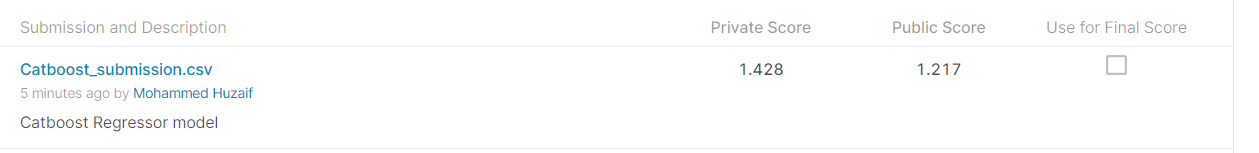

### Catboost Regressor with Regularization

In [37]:
cat_reg = joblib.load('catboost_r_model.sav')
submission = pd.DataFrame()
submission['row_id']=X_test['row_id']

X_test.drop(['row_id'], axis=1, inplace=True)

submission['log_meter_reading']= cat_reg.predict(X_test)
submission['meter_reading']= np.expm1(submission['log_meter_reading'])
submission.drop(['log_meter_reading'], axis=1,inplace=True)
submission.to_csv('Catboost_reg_submission.csv', index=False)

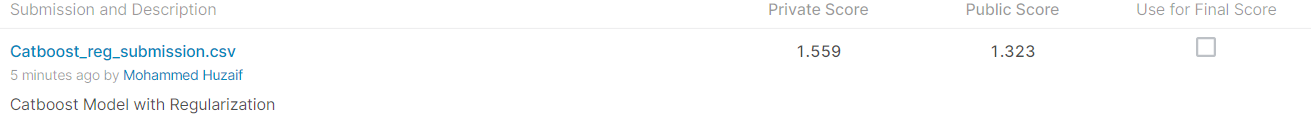

### XGB Regressor with L2 Regularization

In [9]:
xgb_reg = joblib.load('xgb_regressor_l2_model.sav')
submission = pd.DataFrame()
submission['row_id']=X_test['row_id']

X_test.drop(['row_id'], axis=1, inplace=True)

submission['log_meter_reading']= xgb_reg.predict(X_test)
submission['meter_reading']= np.expm1(submission['log_meter_reading'])
submission.drop(['log_meter_reading'], axis=1,inplace=True)
submission.to_csv('XGB_L2_submission.csv', index=False)

[11:33:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


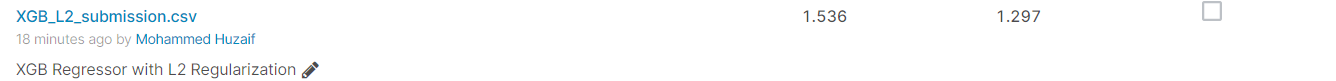

### XGB Regressor with L1 Regularization

In [4]:
xgb_reg = joblib.load('xgb_regressor_l1_model.sav')
submission = pd.DataFrame()
submission['row_id']=X_test['row_id']

X_test.drop(['row_id'], axis=1, inplace=True)

submission['log_meter_reading']= xgb_reg.predict(X_test)
submission['meter_reading']= np.expm1(submission['log_meter_reading'])
submission.drop(['log_meter_reading'], axis=1,inplace=True)
submission.to_csv('XGB_L1_submission.csv', index=False)

[11:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


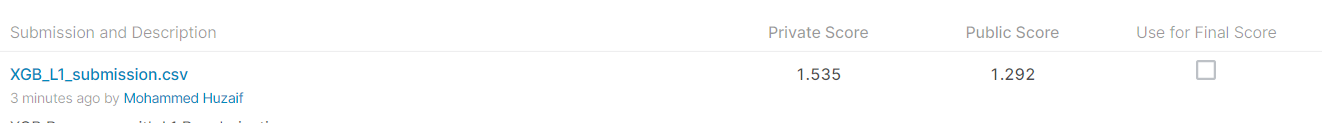